# 6. Linear Model Selection and Regularisation – Labs

Excercises from **Chapter 6** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy import stats

%matplotlib inline

## 8. In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.

(a) Use the rnorm() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [70]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = eps = np.random.normal(0 ,1 , 100)

(b) Generate a response vector Y of length n = 100 according to the model $Y = β_0 +β_1 X +β_2 X^2 +β_3 X^3 +ε$ , where β0, β1, β2, and β3 are constants of your choice.


In [71]:
y_np = 2 + 2*x + 3*(x**2) + 2.5*(x**3) + eps

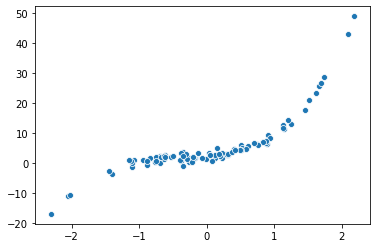

In [72]:
sns.scatterplot(x=x, y=y_np);

(c) Use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors X,X2,...,X10. What is the best model obtained according to Cp, BIC, and adjusted R2? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the data.frame() function to create a single data set containing both X and Y .

In [73]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]

In [74]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done


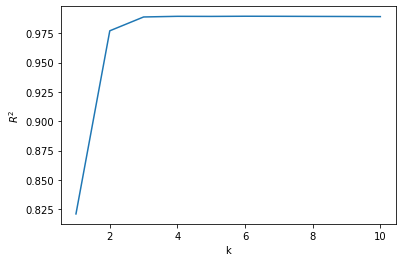

Model selected: 
Intercept    2.298519
X            2.659149
X2           2.617578
X5           2.279830
X7          -0.684882
X9           0.065720
X10          0.001195
dtype: float64


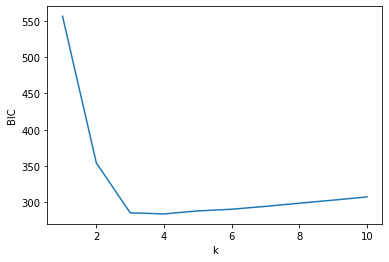

Model selected: 
Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


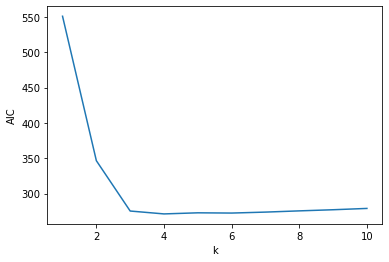

Model selected: 
Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


In [75]:
# Get predictor count
k = np.arange(1, len(X.columns)+1)

# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))

# Plot best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

# Select best subset
coefs_r2 = [(max_adjr2(m)[1].rsquared_adj, max_adjr2(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(max(coefs_r2)[1]))


# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))

# Get best BIC
bic = [min_bic(m)[1].bic for m in model_subsets]

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

# Select best subset
coefs_bic = [(min_bic(m)[1].bic, min_bic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_bic)[1]))


# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))

# Get best AIC
aic = [min_aic(m)[1].aic for m in model_subsets]

sns.lineplot(x=k, y=aic)
plt.xlabel('k')
plt.ylabel('AIC')
plt.show()

# Select best subset
coefs_aic = [(min_aic(m)[1].aic, min_aic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_aic)[1]))


**Comment:** RSS chooses a model with too many features as expected due to overfitting. BIC and AIC try to compensate for overfitting, and do a reasonable job choosing a model with one superfluous feature.

### (d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?

First set up some functions

In [76]:
def forward_stepwise(X, y, scorer='ssr', results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds}).drop(0)
    
    # Get score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = '{} ~ {}'.format(y.columns[0], '+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r    += [(model, [p]+p_used)]
    
    # Choose predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 
                        
    new_results = results + [best_score]
    # Recursive call to self
    return forward_stepwise(X, y, scorer, new_results)

In [77]:
def backward_stepwise(X, y, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise(X, y, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise(X, y, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise(X, y, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise(X, y, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise(X, y, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    ax = sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))

#### Forward stepwise selection

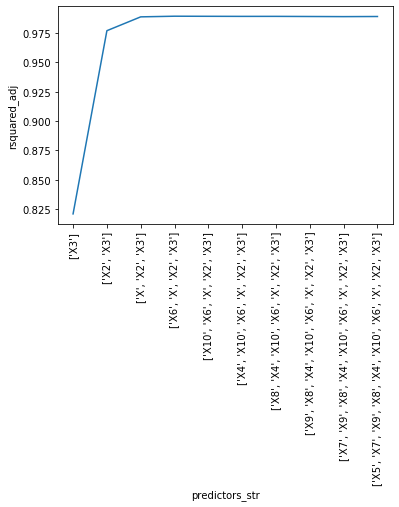

,rsquared_adj,predictors
4,0.989408,"[X6, X, X2, X3]"


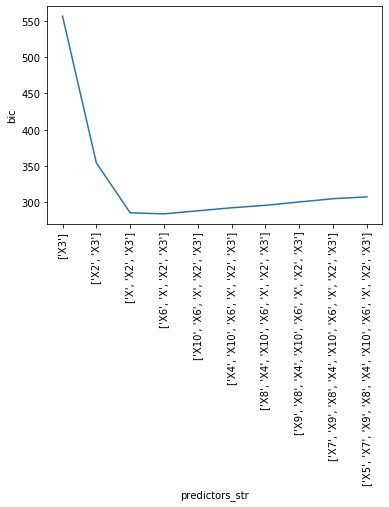

,bic,predictors
4,284.249198,"[X6, X, X2, X3]"


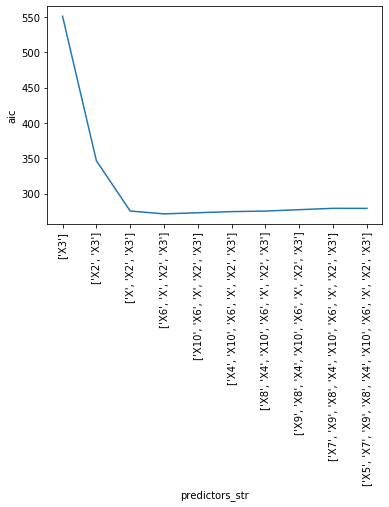

,aic,predictors
4,271.223347,"[X6, X, X2, X3]"


In [78]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

#### Backward stepwise selection

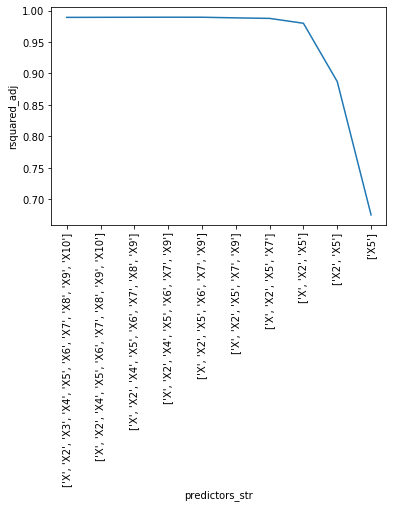

,rsquared_adj,predictors
3,0.989431,"[X, X2, X4, X5, X6, X7, X9]"


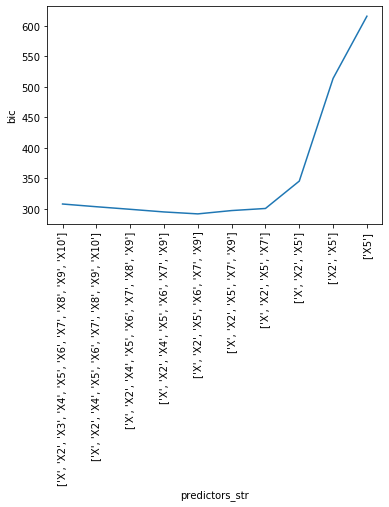

,bic,predictors
4,291.450514,"[X, X2, X5, X6, X7, X9]"


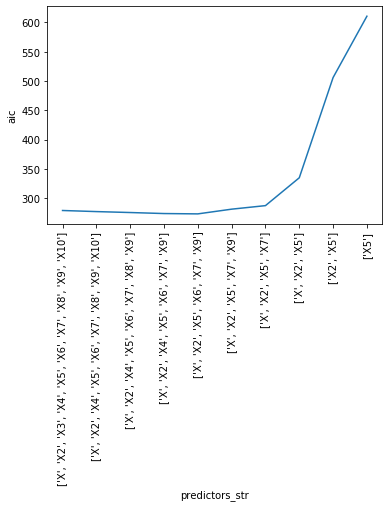

,aic,predictors
4,273.214322,"[X, X2, X5, X6, X7, X9]"


In [79]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

**Comment:**

Forward stepwise selection chooses the same models as best susbset selection for all metrics.

Backward stepwise selection tends to select overly complex models in this setting with 3-4 superfluous features depending on the metric used. 

**Revision note:** It seems somewhat down to chance as to which approach – forward or backward – will work best in a giving setting. In reality without simulation we won't have the luxury of knowing the true optimum, so how do we choose?

### (e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

In [80]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=False, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

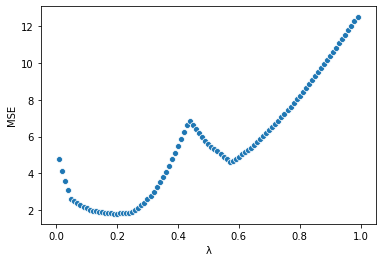

In [81]:
lambdas = np.arange(0.01, 1, 0.01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [82]:
min(zip(MSEs, lambdas))

(1.8145436278959726, 0.19)

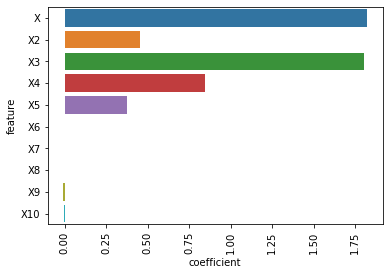

,feature,coefficient
0,X,1.823572
1,X2,0.454881
2,X3,1.802128
3,X4,0.847043
4,X5,0.373082
5,X6,0.000000
6,X7,0.000000
7,X8,-0.000000
8,X9,-0.009186
9,X10,-0.002988


In [83]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

Here the Lasso selects the correct features plus 4 superfluous paramaeters – 2 of which have ver low coeeficients.


#### Feature normalisation

It is possible to get a lower MSE by enabling sklearns feature normalisation as demonstrated below, different features are then selected.

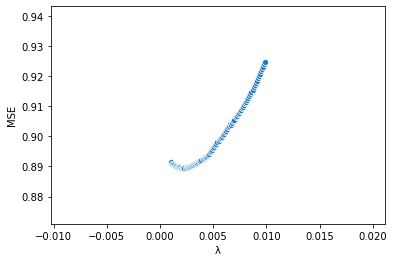

In [84]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

lambdas = np.arange(0.001, 0.01, 0.0001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [85]:
min(zip(MSEs, lambdas))

(0.8894063503790954, 0.0022000000000000006)

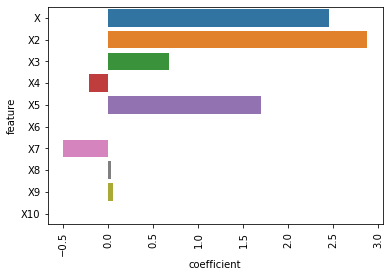

,feature,coefficient
0,X,2.446150
1,X2,2.876938
2,X3,0.678915
3,X4,-0.218099
4,X5,1.698335
5,X6,-0.000000
6,X7,-0.503101
7,X8,0.028357
8,X9,0.047248
9,X10,-0.003263


In [86]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

With feature normalisation the model selects 6 superfluous feautures, 3 with significant coefficients.

**Revision Notes:**

- is the effect of feature normalisation significant?
- if so, why does it have an effect?

### (f) Now generate a response vector Y according to the model $Y = β_0 + β_7 X^7 + ε$ , and perform best subset selection and the lasso. Discuss the results obtained.


#### Create simulated data

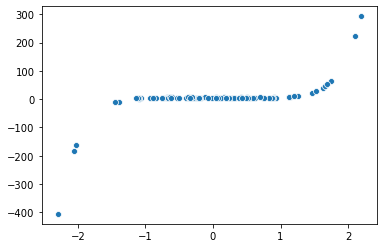

In [87]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = np.random.normal(0 ,1 , 100)

y_np = 5 + 1.2*(x**7) + eps

sns.scatterplot(x=x, y=y_np);

In [88]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

#### Best subset selection

In [89]:
def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]


def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


# Intended API
# ----------------------------------------------

def best_subset(X, y, scorer='ssr'):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))

    # Select best in each subset using chosen scorer
    if scorer == 'ssr':
        # Get best rss score for each subset
        return [min_rss(m) for m in model_subsets]
    elif scorer == 'rsquared_adj':
        # Get best rss score for each subset
        return [max_adjr2(m) for m in model_subsets]       
    elif scorer == 'bic':
        # Get best rss score for each subset
        return [min_bic(m) for m in model_subsets]
    elif scorer == 'aic':
        # Get best rss score for each subset
        return [min_aic(m) for m in model_subsets]

    
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return (MSEs, formula)

In [90]:
# get all model results
best_subset_models = best_subset(X, y, scorer='bic')

Best subset selected: k = 1/10, done
Best subset selected: k = 2/10, done
Best subset selected: k = 3/10, done
Best subset selected: k = 4/10, done
Best subset selected: k = 5/10, done
Best subset selected: k = 6/10, done
Best subset selected: k = 7/10, done
Best subset selected: k = 8/10, done
Best subset selected: k = 9/10, done
Best subset selected: k = 10/10, done


,formula,mse
2,y ~ X2 + X6 + X7,0.854173


Intercept    5.271801
X2          -0.320021
X6           0.020727
X7           1.203961
dtype: float64

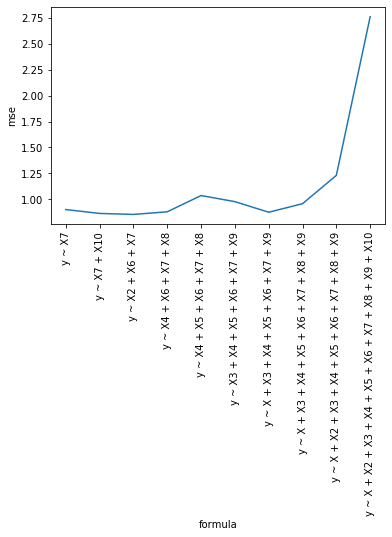

In [91]:
# Parse results
best_subset_formula = [f[0] for f in best_subset_models]
best_subset_mses    = [np.mean(cross_val(f, X, y, 10)[0]) for f in best_subset_formula]
df = pd.DataFrame({'formula': best_subset_formula, 'mse': best_subset_mses})

# Show chosen model
display(df[df['mse'] == df['mse'].min()])
best_subset_params = best_subset_models[2][1].params
display(best_subset_params)

# Plot mse across subsets
ax = sns.lineplot(x='formula', y='mse', data=df, sort=False)
plt.xticks(rotation=90)
plt.show();

Best subset selection with 10 fold cross validation selects a the model, y ~ X2 + X6 + X7 with a MSE of 0.854. 

Because this is simulated data we know that the true model is:

$f(x) = 5 + 1.2 x^7 + ε$

Best subset selection estimates the f(x) to be:

$f(x) = 5.27 - 0.32x^2 + 0.02x^6 + 1.20 x^7$

...which is pretty close. Let's plot on the same axis to see how close

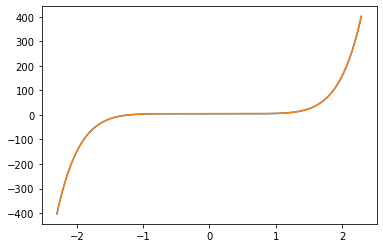

In [92]:
x = np.arange(-2.3, 2.3, 0.01)
sns.lineplot(x=x, y=5 + 1.2*(x**7))
sns.lineplot(x=x, y=5.27 - 0.32*(x**2) + 0.02*(x**6) + 1.20*(x**7));

Here we plot the actual values of y (blue) and the predicted values of y (orange) on the same axis. You can't see the actual line because th eprediction is so close.

#### The Lasso

In [93]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs


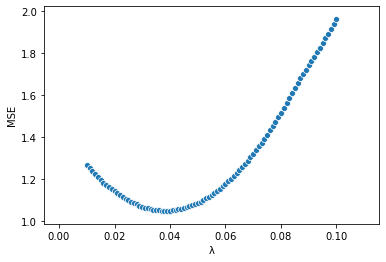

In [94]:
lambdas = np.arange(0.01, 0.1, 0.001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [95]:
min(zip(MSEs, lambdas))

(1.0480683621468974, 0.03799999999999998)

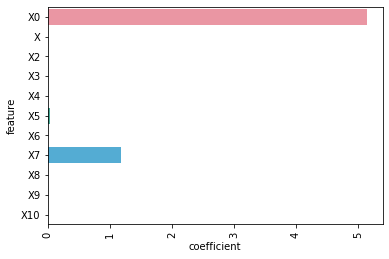

,feature,coefficient
0,X0,5.139609
1,X,0.000000
2,X2,-0.000000
3,X3,0.000000
4,X4,0.000000
5,X5,0.038360
6,X6,0.000000
7,X7,1.186933
8,X8,0.000000
9,X9,0.000000


In [96]:
# What coefficients does the lasso choose for the optimal lambda value?
λ = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X, y)
intercept  = pd.DataFrame({'feature': 'X0', 'coefficient': model.intercept_})
lasso_a_df = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}), ignore_index=True)
ax = sns.barplot(x='coefficient', y='feature', data=lasso_a_df);
plt.xticks(rotation=90)
plt.show();

display(lasso_a_df)

Here the lasso selects almost the ideal model, with only one superfluous feature with a low coefficient. The MSE reported is marginally lower than for best subset selection at 1.048 compared to 0.854. 

Whilst searching for optimal value of lambda, I noticed another minima close to zero... deomonstrated below.

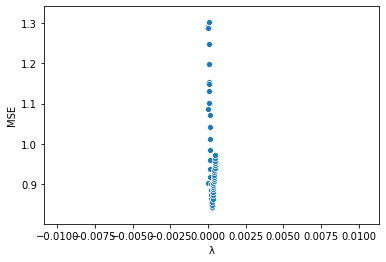

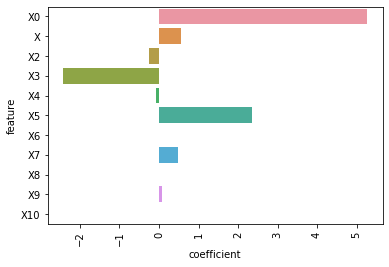

,feature,coefficient
0,X0,5.275241
1,X,0.546472
2,X2,-0.261390
3,X3,-2.428896
4,X4,-0.088259
5,X5,2.363543
6,X6,0.000000
7,X7,0.469777
8,X8,0.006829
9,X9,0.071042


In [97]:
lambdas = np.arange(0.000001, 0.0005, 0.00001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

# What coefficients does the lasso choose for the optimal lambda value?
λ = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X, y)
intercept  = pd.DataFrame({'feature': 'X0', 'coefficient': model.intercept_})
lasso_b_df = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}), ignore_index=True)
ax = sns.barplot(x='coefficient', y='feature', data=lasso_b_df);
plt.xticks(rotation=90)
plt.show();

display(lasso_b_df)

In [98]:
min(zip(MSEs, lambdas))

(0.8423025784930914, 0.00026100000000000006)

Here the value of lambda is very close to zero and so we expect it behave like ridge regression – indeed there is a low proportion of zero value coefficients. 

The MSE is now lower 0.842 than that achieved for both best subset selection and the first version of lasso.

#### But how do these various model estimates compare against the actual f(x)?

Because data is simulated, we can compare the selected models to the actual model


In [99]:
x   = np.random.normal(0, 1, 100)
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
X_np = np.insert(np.array(X), 0, 1, axis=1)

y_actual = 5 + 1.2*(x**7)
bss_params = np.zeros(11)
bss_params[0] = best_subset_params[0]
bss_params[2] = best_subset_params[1]
bss_params[6] = best_subset_params[2]
bss_params[7] = best_subset_params[3]

lasso_a_params = np.array(lasso_a_df['coefficient'])
lasso_b_params = np.array(lasso_b_df['coefficient'])

In [100]:
y_bss     = X_np @ bss_params
y_lasso_a = X_np @ lasso_a_params
y_lasso_b = X_np @ lasso_b_params

In [101]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [102]:
display(HTML('<h4>Actual MSEs compared to known f(x)</h4>'))
print('Best subset selection    : {}'.format(mse(y_bss, y_actual)))
print('Lasso a (higher lambda)  : {}'.format(mse(y_lasso_a, y_actual)))
print('Lasso b (lower lambda ~0): {}'.format(mse(y_lasso_b, y_actual)))

Best subset selection    : 0.5015558203750072
Lasso a (higher lambda)  : 0.23328025069854763
Lasso b (lower lambda ~0): 5.483599366482203


Here we used three seperate approaches to estimate the mode f(x) in a simulated context with noise added. We tested the estimated model for each aproach against the true f(x) without noise.

Best subset selection and ridge-regression (lasso b) produced the lowest CV mse, but lasso a achieved the lowest MSE when compared with the true model f(x). The lasso a was also most effective at ignoring superfluous feautures.

It seems that lasso_a performed best because it ignored irrelavant features and so minimised overfitting. The cross-validation CV was not able to account for this advantage.